In [1]:
!pip install featuretools[tsfresh]
!pip show featuretools

zsh:1: no matches found: featuretools[tsfresh]
Name: featuretools
Version: 1.14.0
Summary: a framework for automated feature engineering
Home-page: 
Author: 
Author-email: "Alteryx, Inc." <open_source_support@alteryx.com>
License: BSD 3-clause
Location: /Users/sjkang/miniforge3/envs/tensorflow/lib/python3.9/site-packages
Requires: click, cloudpickle, dask, distributed, holidays, numpy, packaging, pandas, psutil, scipy, tqdm, woodwork
Required-by: 


In [2]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
###Transformations

In [4]:
import numpy as np

np.random.seed(0)
pts = 10000
vals = np.random.lognormal(0, 1.0, pts)

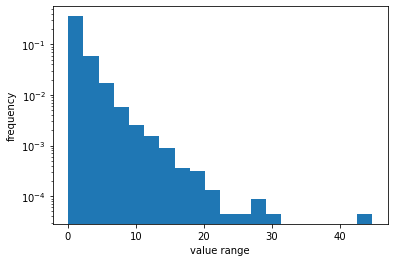

In [5]:
plt.hist(vals, bins=20, density=True)
plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range");

In [6]:
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest

vals_mm = minmax_scale(vals)
scaler = StandardScaler()
vals_ss = scaler.fit_transform(vals.reshape(-1, 1))
_, p = normaltest(vals_ss.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


In [7]:
_, p = normaltest(vals_mm.squeeze())
print(f"significance: {p:.2f}")

significance: 0.00


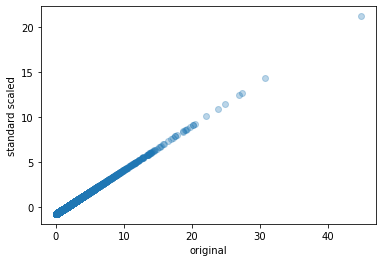

In [8]:
plt.scatter(vals, vals_ss, alpha=0.3)
plt.ylabel("standard scaled")
plt.xlabel("original");

In [9]:
from statsmodels.stats.diagnostic import kstest_normal

log_transformed = np.log(vals)
_, p = kstest_normal(log_transformed)  # stats.normaltest
print(f"significance: {p:.2f}")

significance: 0.31


In [11]:
np.std(log_transformed)

0.9875565681761207

In [12]:
np.mean(log_transformed)

-0.01843372015826582

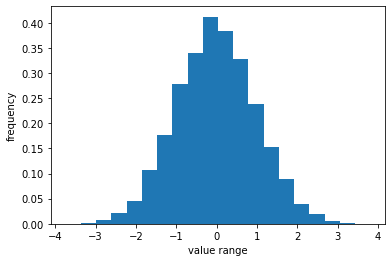

In [13]:
plt.hist(log_transformed, bins=20, density=True)
#plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("value range");

In [14]:
from scipy.stats import boxcox
vals_bc = boxcox(vals, 0.0)
_, p = normaltest(vals_bc)
print(f"significance: {p:.2f}")

significance: 0.46


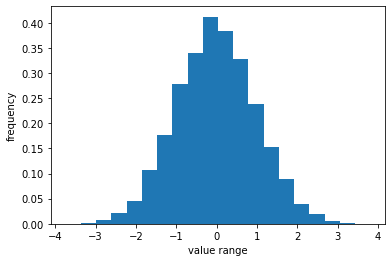

In [15]:
plt.hist(vals_bc, bins=20, density=True)
plt.ylabel("frequency")
plt.xlabel("value range");

In [16]:
##Derived Date Features

In [17]:
#Holidays

In [18]:
from workalendar.europe.united_kingdom import UnitedKingdom
UnitedKingdom().holidays()

[(datetime.date(2022, 1, 1), 'New year'),
 (datetime.date(2022, 1, 3), 'New Year shift'),
 (datetime.date(2022, 4, 15), 'Good Friday'),
 (datetime.date(2022, 4, 17), 'Easter Sunday'),
 (datetime.date(2022, 4, 18), 'Easter Monday'),
 (datetime.date(2022, 5, 2), 'Early May Bank Holiday'),
 (datetime.date(2022, 6, 2), 'Spring Bank Holiday'),
 (datetime.date(2022, 6, 3), 'Queen’s Platinum Jubilee bank holiday'),
 (datetime.date(2022, 8, 29), 'Late Summer Bank Holiday'),
 (datetime.date(2022, 9, 19), 'State Funeral of Queen Elizabeth II'),
 (datetime.date(2022, 12, 25), 'Christmas Day'),
 (datetime.date(2022, 12, 26), 'Boxing Day'),
 (datetime.date(2022, 12, 26), 'Christmas Shift'),
 (datetime.date(2022, 12, 27), 'Boxing Day Shift')]

In [19]:
from typing import List
from dateutil.relativedelta import relativedelta, TH
import datetime
from workalendar.usa import California

def create_custom_holidays(year) -> List:
      custom_holidays = California().holidays()
      custom_holidays.append((
        (datetime.datetime(year, 11, 1) + relativedelta(weekday=TH(+4)) + datetime.timedelta(days=1)).date(),
        "Black Friday"
      ))
      return {k: v for (k, v) in custom_holidays}

custom_holidays = create_custom_holidays(2021)

In [20]:
custom_holidays

{datetime.date(2021, 12, 31): 'New year (Observed)',
 datetime.date(2022, 1, 1): 'New year',
 datetime.date(2022, 1, 17): 'Birthday of Martin Luther King, Jr.',
 datetime.date(2022, 2, 21): "Washington's Birthday",
 datetime.date(2022, 3, 31): 'Cesar Chavez Day',
 datetime.date(2022, 5, 30): 'Memorial Day',
 datetime.date(2022, 7, 4): 'Independence Day',
 datetime.date(2022, 9, 5): 'Labor Day',
 datetime.date(2022, 11, 11): 'Veterans Day',
 datetime.date(2022, 11, 24): 'Thanksgiving Day',
 datetime.date(2022, 11, 25): 'Thanksgiving Friday',
 datetime.date(2022, 12, 25): 'Christmas Day',
 datetime.date(2022, 12, 26): 'Christmas Day (Observed)',
 datetime.date(2021, 11, 26): 'Black Friday'}

In [21]:
def is_holiday(current_date: datetime.date):
    """Determine if we have a holiday."""
    return custom_holidays.get(current_date, False)

today = datetime.date(2021, 4, 11)
is_holiday(today)

False

In [23]:
###Date Annotations

In [24]:
import calendar

calendar.monthrange(2021, 1)

(4, 31)

In [25]:
from datetime import date
def year_anchor(current_date: datetime.date):
      return (
        (current_date - date(current_date.year, 1, 1)).days,
        (date(current_date.year, 12, 31) - current_date).days,
      )

year_anchor(today)

(100, 264)

In [26]:
def month_anchor(current_date: datetime.date):
      last_day = calendar.monthrange(current_date.year, current_date.month)[0]
    
      return (
        (current_date - datetime.date(current_date.year, current_date.month, 1)).days,
        (current_date - datetime.date(current_date.year, current_date.month, last_day)).days,
      )

month_anchor(today)

(10, 8)

In [ ]:
###Seasons

In [27]:
YEAR = 2021
seasons = [
    ('winter', (date(YEAR,  1,  1),  date(YEAR,  3, 20))),
    ('spring', (date(YEAR,  3, 21),  date(YEAR,  6, 20))),
    ('summer', (date(YEAR,  6, 21),  date(YEAR,  9, 22))),
    ('autumn', (date(YEAR,  9, 23),  date(YEAR, 12, 20))),
    ('winter', (date(YEAR, 12, 21),  date(YEAR, 12, 31)))
]

def is_in_interval(current_date: datetime.date, seasons):
      return next(season for season, (start, end) in seasons
                if start <= current_date.replace(year=YEAR) <= end)
    
is_in_interval(today, seasons)

'spring'

In [ ]:
###Sun and Moon

In [28]:
from datetime import date,time
##from datetime import datetime
from datetime import timedelta
from astral.sun import sun
from astral import LocationInfo
CITY = LocationInfo("London", "England", "Europe/London", 51.5, -0.116)
def get_sunrise_dusk(current_date: datetime.date, city_name='London'):
      s = sun(CITY.observer, date=current_date)
      sunrise = s['sunrise']
      dusk = s['dusk']
      return (sunrise - dusk).seconds / 3600


get_sunrise_dusk(date.today)

AttributeError: 'builtin_function_or_method' object has no attribute 'year'